# Pankreopriver diabetes mellitus vs Diabetes Type 1 

### Libraries

In [1]:
# pd.options.display.max_columns= 999

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [5]:
from skbio.stats.ordination import pcoa

### Data loading

In [136]:
df = pd.read_csv(
    "/data/projects/2024/Effenberger-Diabetes/data/PDM merged 3.0_modified.csv"
)

In [137]:
sample_info = pd.read_csv(
    "/data/projects/2024/Effenberger-Diabetes/data/20011/20011_SampleInfo.csv"
)

In [138]:
df.rename(columns={"Probennummer": "sample_information"}, inplace=True)

In [139]:
sample_info.rename(columns={"SampleInformation": "sample_information"}, inplace=True)

In [140]:
df = df.merge(
    sample_info[["sample_information", "IMGM ID", "Type"]],
    on="sample_information",
    how="left",
)

In [141]:
# Load the dataset
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/barplot/level-6.csv"
df_tax = pd.read_csv(file_path)

In [142]:
df_tax.set_index("index", inplace=True)

In [143]:
# List of columns to exclude (non-bacterial metadata/clinical columns)
exclude_cols = [
    'sample_information', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
    'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
    'BMI1', 'BMI2', 'Pankreatektomie', 'HbA1C_diff', 'Glukose_diff',
    'BMI_diff', 'KHK_diff', 'CA_diff'
]

# Keep only columns that are NOT in exclude_cols
df_tax_bacteria = df_tax.drop(columns=exclude_cols, errors='ignore')

# Define your low abundance threshold (adjust as needed)
threshold = 0.1

# Compute mean abundance per taxon across all samples
mean_abundance = df_tax_bacteria.mean(axis=0)

# Filter for low-abundance taxa
low_abundance_taxa = mean_abundance[mean_abundance < threshold].index

# Create a DataFrame of only low-abundance taxa
df_low_abundance = df_tax_bacteria[low_abundance_taxa]

high_abundance_taxa = mean_abundance[mean_abundance >= threshold].index

# Subset the DataFrame to keep only high-abundance taxa
df_high_abundance = df_tax_bacteria[high_abundance_taxa]


In [144]:
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/diversity/alpha_diversity/shannon_vector/metadata.tsv"
shannon_entropy = pd.read_csv(file_path, sep="\t")
shannon_entropy = shannon_entropy.iloc[1:]

In [145]:
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/diversity/beta_diversity/bray_curtis_distance_matrix-condition/raw_data.tsv"
bray_curtis = pd.read_csv(file_path, sep="\t")
bray_curtis = bray_curtis.iloc[:, 1:]

In [146]:
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/diversity/beta_diversity/jaccard_distance_matrix-condition/raw_data.tsv"
jaccard = pd.read_csv(file_path, sep="\t")
jaccard = jaccard.iloc[:, 1:]

In [147]:
jaccard.head()

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,s20011_0005,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.958784
1,s20011_0009,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.966202
2,s20011_0009,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.955776
3,s20011_0010,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.970096
4,s20011_0010,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.971220


In [148]:
bray_curtis.head()

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,s20011_0005,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.868272
1,s20011_0009,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.826948
2,s20011_0009,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.780646
3,s20011_0010,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.870818
4,s20011_0010,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.883088


### Data cleaning

#### Metadata contains clinical information

In [149]:
metadata_cols = df[
    [
        "IMGM ID",
        "sample_information",
        "Type",
        "age",
        "KHK1",
        "KHK2",
        "CA1",
        "CA2",
        "HbA1C (DCCT/NGSP)1",
        "HbA1C (DCCT/NGSP)2",
        "Glukose1",
        "Glukose2",
        "BMI1",
        "BMI2",
       "Pankreatektomie",'sex','Insulin1','Insulin2', 'MASLD1','MASLD2', 'nikotin',
    ]
]

In [150]:
metadata = metadata_cols.dropna(subset=["IMGM ID"])

In [151]:
metadata["HbA1C_diff"] = metadata.apply(
    lambda x: (
        "increase"
        if x["HbA1C (DCCT/NGSP)2"] - x["HbA1C (DCCT/NGSP)1"] > 0
        else "decrease"
    ),
    axis=1,
)
metadata["Glukose_diff"] = metadata.apply(
    lambda x: "increase" if x["Glukose2"] - x["Glukose1"] > 0 else "decrease", axis=1
)
metadata["BMI_diff"] = metadata.apply(
    lambda x: "increase" if x["BMI2"] - x["BMI1"] > 0 else "decrease", axis=1
)

/tmp/ipykernel_784995/1781552986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["HbA1C_diff"] = metadata.apply(
/tmp/ipykernel_784995/1781552986.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["Glukose_diff"] = metadata.apply(
/tmp/ipykernel_784995/1781552986.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [152]:
# Define a function for categorical difference
def categorize_diff(before, after):
    if after == "ja" and before == "nein":
        return "onset"
    elif after == "nein" and before == "nein":
        return "absent"
    elif after == "nein" and before == "ja":
        return "resolved"
    elif after == "ja" and before == "ja":
        return "persistent"
    else:
        return "unknown"  # Catch any unexpected values


# Apply the function to create the categorical difference columns
metadata["KHK_diff"] = metadata.apply(
    lambda x: categorize_diff(x["KHK1"], x["KHK2"]), axis=1
)
metadata["CA_diff"] = metadata.apply(
    lambda x: categorize_diff(x["CA1"], x["CA2"]), axis=1
)

/tmp/ipykernel_784995/2496625819.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["KHK_diff"] = metadata.apply(
/tmp/ipykernel_784995/2496625819.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["CA_diff"] = metadata.apply(


In [153]:
metadata.rename(columns={"IMGM ID": "id"}, inplace=True)

/tmp/ipykernel_784995/2089906567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.rename(columns={"IMGM ID": "id"}, inplace=True)


In [154]:
# Filter based on sample_information
metadata_k = metadata[metadata["sample_information"].str.contains("K", na=False)]
metadata_dm = metadata[metadata["sample_information"].str.match("DM", na=False)]
metadata_pdm = metadata[metadata["sample_information"].str.contains("PDM", na=False)]

In [155]:
# metadata["id"] = "s"+metadata["id"]
# metadata_dm["id"] = "s"+metadata_dm["id"]
# metadata_pdm["id"] = "s"+metadata_pdm["id"]
# metadata_k["id"] = "s"+metadata_k["id"]

In [156]:
metadata_k = metadata_k.drop_duplicates(subset=["id"], keep="first")
metadata_dm = metadata_dm.drop_duplicates(subset=["id"], keep="first")
metadata_pdm = metadata_pdm.drop_duplicates(subset=["id"], keep="first")

In [157]:
metadata = metadata.drop_duplicates(subset=["id"], keep="first")

#### Microbial data contains taxonomic information from QUIIME

In [158]:
microbial_data = df_high_abundance.drop(columns=metadata_cols, errors="ignore")

In [159]:
microbial_data["id"] = microbial_data.index

In [160]:
# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(";")[-1].strip()

In [161]:
microbial_data.rename(
    columns={col: extract_species_name(col) for col in microbial_data.columns},
    inplace=True,
)

In [162]:
microbial_data.rename(columns={"index": "id"}, inplace=True)

In [163]:
# First, clean up column names to avoid hidden whitespace or capitalization issues
microbial_data.columns = microbial_data.columns.str.strip()
metadata.columns = metadata.columns.str.strip()

# Double check both have 'id' column
print("microbial_data columns:", microbial_data.columns)
print("metadata columns:", metadata.columns)

# If the 'id' column exists in both, proceed with the merge
if "id" in microbial_data.columns and "id" in metadata.columns:
    microbial_data = microbial_data.merge(
        metadata[["id", "Type", "sample_information","age",'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2','Pankreatektomie',#,'sex','Insulin1','Insulin2', 'MASLD1','MASLD2', 'nikotin',
       'BMI1', 'BMI2']], on="id", how="left"
    )
    
    


else:
    print("❌ 'id' column not found in one or both DataFrames.")

microbial_data columns: Index(['', '', '', 'Bacteroides', 'Fusicatenibacter', 'Ruminococcus',
       'Subdoligranulum', 'Prevotella_9', '', '',
       ...
       'Aeromonas', 'CHKCI001', 'DNF00809', 'Succiniclasticum', 'Anaerococcus',
       '', 'Caproiciproducens', '', 'Lachnospiraceae UCG-009', 'id'],
      dtype='object', length=354)
metadata columns: Index(['id', 'sample_information', 'Type', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
       'BMI1', 'BMI2', 'Pankreatektomie', 'sex', 'Insulin1', 'Insulin2',
       'MASLD1', 'MASLD2', 'nikotin', 'HbA1C_diff', 'Glukose_diff', 'BMI_diff',
       'KHK_diff', 'CA_diff'],
      dtype='object')


In [164]:
#microbial_data = microbial_data.loc[:, microbial_data.columns != ""]

In [165]:
# Define a custom ordinal mapping (if 'nein' < 'Teilresektion' < 'Resektion')
ordinal_map = {
    "nein": 0,
    "Teilresektion links": 1,
    "Teilresektion rechts": 2,
    "Resektion": 3
}

# Apply mapping
microbial_data["Pankreatektomie_encoded"] = microbial_data["Pankreatektomie"].map(ordinal_map)


In [166]:
microbial_data_original = microbial_data.copy()

In [167]:
microbial_data = microbial_data.drop(columns=['Pankreatektomie'])

In [37]:
#microbial_data.to_csv("metadata_abundance.csv")

# Filter for low abundance

### Visualization

#### PCA

In [38]:
# Keep only numeric data, keeping index intact
numeric_data = microbial_data.select_dtypes(include="number")

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_data)

# Rebuild the DataFrame with the same index
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=numeric_data.index)

# Add metadata from original microbial_data (safely aligned by index)
pca_df["Type"] = microbial_data["Type"]

In [39]:
explained_var = pca.explained_variance_ratio_

In [40]:
# Get variance explained and format as percentages
explained_var = pca.explained_variance_ratio_ * 100
pc1_label = f"PC1 ({explained_var[0]:.2f}%)"
pc2_label = f"PC2 ({explained_var[1]:.2f}%)"

# Create DataFrame with labels
pca_df = pd.DataFrame(
    pca_result, columns=[pc1_label, pc2_label], index=numeric_data.index
)
pca_df["Type"] = microbial_data["Type"]

In [41]:
pca_df["Type"].replace(
    "Diabetes mellitus Typ1", "Diabetes mellitus Type1", inplace=True
)
pca_df["Type"].replace("pankreopriver Diabetes", "Pankreopriver Diabetes", inplace=True)

/tmp/ipykernel_9091/249817343.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pca_df["Type"].replace(
/tmp/ipykernel_9091/249817343.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: valu

In [42]:
pca_df["Type"] = pca_df["Type"].replace(
    {"Pankreopriver Diabetes": "PDM", "Diabetes mellitus Type1": "DM", "Kontrolle": "K"}
)

In [43]:
import pandas as pd

# Assuming pca_df is already defined
pca_df_scaled = pca_df.copy()
pca_df_scaled[pca_df_scaled.select_dtypes(include="number").columns] *= 0.0001

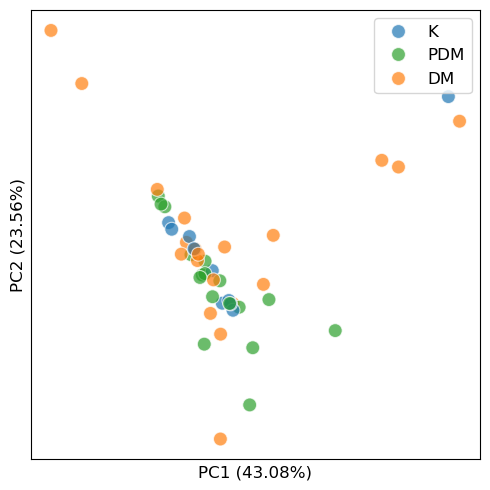

In [46]:
# Define custom color palette
custom_palette = {
    "K": "#1f77b4",  # blue
    "DM": "#ff7f0e",  # orange
    "PDM": "#2ca02c",  # green
}

# Plot PCA results with custom colors
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=pca_df,
    x=pca_df.columns[0],
    y=pca_df.columns[1],
    hue="Type",
    palette=custom_palette,
    alpha=0.7,
    s=100,
)
plt.xticks([])
plt.yticks([])

plt.xlabel(pca_df.columns[0], fontsize=12)
plt.ylabel(pca_df.columns[1], fontsize=12)
plt.title("")
plt.legend(title="", fontsize=12)
plt.tight_layout()
plt.savefig("./figures/v02/pca.svg")
plt.show()

#### Upsetplot / Venn diagram

In [ ]:
# Define metadata columns
metadata_cols = [
    "index",
    "sample_information",
    "Type",
    "nikotin",
    "sex",
    "age_group",
    "AH",
]


# Function to extract and clean microbial data by condition
def extract_microbial_data(df, condition_label):
    subset = df[df["sample_information"].str.startswith(condition_label)]
    microbial_data = subset.drop(columns=metadata_cols, errors="ignore")
    microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]
    microbial_data = microbial_data.loc[
        :, ~microbial_data.columns.str.startswith("Archaea;")
    ]
    return microbial_data


# Create three microbial datasets
microbial_data_PDM = extract_microbial_data(df_tax, "PDM")
microbial_data_DM = extract_microbial_data(df_tax, "DM")
microbial_data_Kontrolle = extract_microbial_data(df_tax, "K")

In [ ]:
# Extract microbial abundance data (exclude metadata)
list_PDM = set(microbial_data_PDM.columns)
list_DM = set(microbial_data_DM.columns)
list_Kontrolle = set(microbial_data_Kontrolle.columns)

In [ ]:
common_PDM_DM = list_PDM & list_DM

In [ ]:
notcommon_PDM_DM = list_PDM ^ list_DM

# Unique to PDM
unique_PDM = list_PDM - list_DM - list_Kontrolle

# Unique to DM
unique_DM = list_DM - list_PDM - list_Kontrolle

# If you want to convert them to sorted lists for display or export:
common_PDM_DM = sorted(list(common_PDM_DM))
unique_PDM = sorted(list(unique_PDM))
unique_DM = sorted(list(unique_DM))

In [ ]:
# Define metadata columns
metadata_cols = [
    "index",
    "sample_information",
    "Type",
    "nikotin",
    "sex",
    "age_group",
    "AH",
]

microbial_data = df_tax.drop(columns=metadata_cols, errors="ignore")
microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]


def extract_microbial_data(df, condition_label):
    subset = df[df["sample_information"].str.startswith(condition_label)]
    microbial_data = subset.drop(columns=metadata_cols, errors="ignore")
    microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]
    return microbial_data


# Create three microbial datasets
microbial_data_PDM = extract_microbial_data(df_tax, "PDM")
microbial_data_DM = extract_microbial_data(df_tax, "DM")

list_PDM = set(microbial_data_PDM.columns)
list_DM = set(microbial_data_DM.columns)

common_PDM_DM = list_PDM - list_DM
# If you want to convert them to sorted lists for display or export:
common_PDM_DM = sorted(list(common_PDM_DM))

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from upsetplot import UpSet, from_memberships

# Assume you already have these:
# microbial_data_PDM, microbial_data_DM, microbial_data_Healthy

# Get sets of taxa present in each group
taxa_PDM = set(microbial_data_PDM.columns)
taxa_DM = set(microbial_data_DM.columns)
taxa_K = set(microbial_data_Kontrolle.columns)


# Create a list of presence/absence combinations
taxa_all = taxa_PDM | taxa_DM | taxa_K

memberships = []
for taxon in taxa_all:
    presence = []
    if taxon in taxa_PDM:
        presence.append("PDM")
    if taxon in taxa_DM:
        presence.append("DM")
    if taxon in taxa_K:
        presence.append("K")

    memberships.append(presence)

# Convert to format UpSet needs
data = from_memberships(memberships)

# Plot UpSet
plt.figure(figsize=(10, 6))
UpSet(data, subset_size="count", show_counts=True).plot()
plt.title("")
plt.tight_layout()
plt.savefig("./figures/v02/upsetplot.svg")
plt.show()


# Unique to PDM
shared_PDM_DM_only = (taxa_PDM & taxa_DM) - taxa_K

# Unique to DM
unique_PDM = taxa_PDM - taxa_DM - taxa_K

# Unique to DM
unique_DM = taxa_DM - taxa_PDM - taxa_K

# Unique to DM
unique_K = taxa_K - taxa_DM - taxa_PDM

#### Volcano

In [ ]:
microbial_data_original = microbial_data_original.loc[
    :, microbial_data_original.columns != ""
]

In [ ]:
df_filtered = microbial_data_original[
    microbial_data_original["Type"].isin(
        ["pankreopriver Diabetes", "Diabetes mellitus Typ1"]
    )
].copy()
df_filtered["condition"] = df_filtered["Type"].map(
    {"pankreopriver Diabetes": 1, "Diabetes mellitus Typ1": 0}
)

In [ ]:
df_filtered_original = df_filtered.copy()

In [ ]:
# df_filtered = df_filtered_original

In [ ]:
df_filtered = df_filtered.set_index("id")

In [ ]:
results = []

In [ ]:
df_filtered = df_filtered.select_dtypes(include="number")

In [ ]:
from patsy import EvalFactor, ModelDesc, Term, dmatrix

results = []
for taxon in df_filtered.columns:
    if taxon == "condition":
        continue

    try:
        df_filtered[taxon] = pd.to_numeric(df_filtered[taxon], errors="coerce")

        # Safely wrap the taxon name
        formula = f"Q('{taxon}') ~ condition"

        # Fit Negative Binomial model
        model = smf.glm(
            formula, data=df_filtered, family=sm.families.NegativeBinomial()
        ).fit()
        log_fold_change = model.params["condition"]
        p_value = model.pvalues["condition"]
        results.append((taxon, log_fold_change, p_value))
    except Exception as e:
        print(f"Skipping {taxon}: {e}")
        continue

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Taxon", "Log2 Fold Change", "p-value"])

# Adjust p-values using Benjamini-Hochberg (FDR correction)
results_df["Adjusted p-value"] = multipletests(results_df["p-value"], method="fdr_bh")[
    1
]

# Create a Volcano Plot to visualize differential abundance results

# Define significance threshold
significance_threshold = 0.01

results_df["Significance"] = (results_df["Adjusted p-value"] < 0.01) & (
    results_df["Log2 Fold Change"].abs() > 1
)


# Create a new column for significance labeling
# results_df["Significance"] = results_df["Adjusted p-value"] < significance_threshold

In [ ]:
# Create Volcano Plot
plt.figure(figsize=(5, 10))
sns.scatterplot(
    x=results_df["Log2 Fold Change"],
    y=-np.log10(results_df["Adjusted p-value"]),
    hue=results_df["Significance"],
    palette={True: "red", False: "gray"},
    edgecolor="black",
    alpha=0.7,
)

# Add labels for significant points
for i, row in results_df.iterrows():
    if row["Significance"]:
        plt.text(
            row["Log2 Fold Change"],
            -np.log10(row["Adjusted p-value"]),
            row["Taxon"],
            fontsize=15,
            ha="right",
        )


logfoldchange_threshold = 1
# Labels and title
plt.axhline(
    -np.log10(significance_threshold), linestyle="--", color="blue", linewidth=1
)  # Threshold line
plt.axvline(
    x=-logfoldchange_threshold, linestyle="--", color="black", linewidth=1
)  # Log2FC negative threshold
plt.axvline(
    x=logfoldchange_threshold, linestyle="--", color="black", linewidth=1
)  # Log2FC positive threshold
plt.xlabel(
    "Log2FC",
    fontsize=15,
)
plt.ylabel(
    "-log10(p.ajust)",
    fontsize=15,
)
plt.title("PDM vs. DM")
plt.legend(title="FDR < 0.01", loc="upper right")
plt.xlim(-25, 25)
# plt.savefig("volcano_pdm_dn.svg")
# Show plot
plt.show()

#### Boxplot - Alpha diversity

In [47]:
shannon_entropy = shannon_entropy.merge(
    metadata[["id", "Type", "sample_information"]], on="id", how="left"
)

In [48]:
shannon_entropy.head()

,id,KHK1,KHK2,CA1,CA2,Pankreatektomie,HbA1C_diff,Glukose_diff,BMI_diff,KHK_diff,CA_diff,shannon_entropy,Type,sample_information
0,s20011_0048,ja,nein,ja,ja,Teilresektion rechts,increase,increase,increase,resolved,persistent,7.57977458353132,pankreopriver Diabetes,PDM12
1,s20011_0023,ja,ja,ja,ja,nein,decrease,decrease,decrease,persistent,persistent,5.76206650928764,pankreopriver Diabetes,PDM17
2,s20011_0019,nein,nein,nein,nein,nein,decrease,decrease,increase,absent,absent,5.90108494358752,Diabetes mellitus Typ1,DM4
3,s20011_0002,ja,ja,nein,nein,nein,increase,decrease,increase,persistent,absent,5.92288227633451,pankreopriver Diabetes,PDM1
4,s20011_0007,ja,ja,nein,nein,nein,decrease,increase,decrease,persistent,absent,6.16695450601612,pankreopriver Diabetes,PDM2


In [49]:
shannon_entropy["Type"].replace("Diabetes mellitus Typ1", "DM", inplace=True)
shannon_entropy["Type"].replace("pankreopriver Diabetes", "PDM", inplace=True)

/tmp/ipykernel_9091/2786416197.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  shannon_entropy["Type"].replace("Diabetes mellitus Typ1", "DM", inplace=True)
/tmp/ipykernel_9091/2786416197.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].metho

In [50]:
shannon_entropy["Type"] = shannon_entropy["Type"].replace({"Kontrolle": "K"})

/tmp/ipykernel_9091/3863120512.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


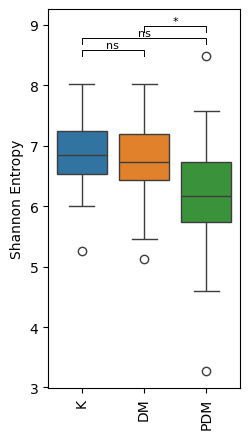

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Order and palette
order = ["K", "DM", "PDM"]
custom_palette = {
    "K": "#1f77b4",
    "DM": "#ff7f0e",
    "PDM": "#2ca02c",
}

# Clean data
df_clean = shannon_entropy[
    pd.to_numeric(shannon_entropy["shannon_entropy"], errors="coerce").notnull()
].copy()
df_clean["shannon_entropy"] = df_clean["shannon_entropy"].astype(float)

# Create plot
plt.figure(figsize=(2.6, 4.5))
ax = sns.boxplot(
    data=df_clean, x="Type", y="shannon_entropy", palette=custom_palette, order=order
)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Shannon Entropy")

# ---- Add significance stars ---- #
comparisons = [("K", "DM"), ("K", "PDM"), ("PDM", "DM")]
y_max = df_clean["shannon_entropy"].max()
h = 0.2  # height offset between comparisons

for i, (group1, group2) in enumerate(comparisons):
    x1, x2 = order.index(group1), order.index(group2)
    y1 = df_clean[df_clean["Type"] == group1]["shannon_entropy"]
    y2 = df_clean[df_clean["Type"] == group2]["shannon_entropy"]

    stat, p = mannwhitneyu(y1, y2, alternative="two-sided")

    # Determine significance stars
    if p < 0.001:
        star = "***"
    elif p < 0.01:
        star = "**"
    elif p < 0.05:
        star = "*"
    else:
        star = "ns"

    # Plot the line and text
    y_line = y_max + h * i
    ax.plot(
        [x1, x1, x2, x2],
        [y_line, y_line + 0.1, y_line + 0.1, y_line],
        lw=0.7,
        c="black",
    )
    ax.text((x1 + x2) / 2, y_line + 0.1, star, ha="center", va="bottom", fontsize=8)
#plt.savefig("./figures/v02/alpha.svg")
plt.tight_layout()
plt.show()

#### Boxplot - Beta diversity

In [59]:
jaccard.head()

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,s20011_0005,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.958784
1,s20011_0009,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.966202
2,s20011_0009,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.955776
3,s20011_0010,s20011_0004,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.970096
4,s20011_0010,s20011_0005,Diabetes mellitus Typ1,Diabetes mellitus Typ1,0.971220


In [60]:
from skbio.stats.distance import DistanceMatrix

In [61]:
from skbio.stats.distance import _permanova

In [62]:
df = jaccard

In [63]:
df["Group1"].replace("Diabetes mellitus Typ1", "DM",inplace=True)
df["Group1"].replace("pankreopriver Diabetes", "PDM",inplace=True)
df["Group1"].replace("Kontrolle","K",inplace=True)
df["Group2"].replace("Diabetes mellitus Typ1", "DM",inplace=True)
df["Group2"].replace("pankreopriver Diabetes", "PDM",inplace=True)
df["Group2"].replace("Kontrolle","K",inplace=True)

/tmp/ipykernel_784995/1255490065.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Group1"].replace("Diabetes mellitus Typ1", "DM",inplace=True)
/tmp/ipykernel_784995/1255490065.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

In [64]:
df

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,s20011_0005,s20011_0004,DM,DM,0.958784
1,s20011_0009,s20011_0004,DM,DM,0.966202
2,s20011_0009,s20011_0005,DM,DM,0.955776
3,s20011_0010,s20011_0004,DM,DM,0.970096
4,s20011_0010,s20011_0005,DM,DM,0.971220
...,...,...,...,...,...
1860,s20011_0048,s20011_0026,PDM,K,0.969790
1861,s20011_0048,s20011_0031,PDM,K,0.983129
1862,s20011_0048,s20011_0035,PDM,K,0.967877
1863,s20011_0048,s20011_0039,PDM,K,0.966736


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import kruskal

order = ["K", "DM", "PDM"]
custom_palette = {
    "K": "#1f77b4",
    "DM": "#ff7f0e",
    "PDM": "#2ca02c",
}
# Get unique groups
unique_groups = sorted(set(df["Group1"]) | set(df["Group2"]))

# Loop through each group as reference
for ref_group in unique_groups:
    # Filter pairs that include the reference group
    df_sub = df[(df["Group1"] == ref_group) | (df["Group2"] == ref_group)].copy()

    # Assign comparison group
    df_sub["Comparison"] = df_sub.apply(
        lambda row: row["Group2"] if row["Group1"] == ref_group else row["Group1"],
        axis=1,
    )

    # Run Kruskal-Wallis test
    grouped = df_sub.groupby("Comparison")["Distance"].apply(list)
    if len(grouped) > 1:
        stat, p_value = kruskal(*grouped)
    else:
        stat, p_value = float("nan"), float("nan")

    # Plot
    plt.figure(figsize=(2.6, 4.5))
    ax = sns.boxplot(data=df_sub, x="Comparison", y="Distance", palette=custom_palette,)
    plt.title(f"Distance to {ref_group}")
    #plt.xlabel(f"Distance to {ref_group}")
    plt.ylabel("Distance")
    plt.xticks(rotation=90)
    plt.tight_layout()

   

    # Save or show plot
    plt.savefig(f"./figures/v02/distance_vs_{ref_group.replace(' ', '_')}.svg")
    plt.show()
    

In [ ]:
import uuid

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skbio.stats.distance import DistanceMatrix, permanova

# Get unique groups
unique_groups = sorted(set(df["Group1"]) | set(df["Group2"]))

for ref_group in unique_groups:
    df_sub = df[(df["Group1"] == ref_group) | (df["Group2"] == ref_group)].copy()

    # Unique sample names
    df_sub["Sample1"] = (
        df_sub["Group1"] + "_" + df_sub["Group1"].apply(lambda x: str(uuid.uuid4())[:8])
    )
    df_sub["Sample2"] = (
        df_sub["Group2"] + "_" + df_sub["Group2"].apply(lambda x: str(uuid.uuid4())[:8])
    )

    all_samples = list(set(df_sub["Sample1"]) | set(df_sub["Sample2"]))
    sample_map = {s: s.split("_")[0] for s in all_samples}

    # Initialize square distance matrix
    dist_df = pd.DataFrame(0.0, index=all_samples, columns=all_samples)

    for _, row in df_sub.iterrows():
        s1, s2, d = row["Sample1"], row["Sample2"], row["Distance"]
        dist_df.loc[s1, s2] = d
        dist_df.loc[s2, s1] = d

    # Create DistanceMatrix and group vector
    dm = DistanceMatrix(dist_df.values, ids=dist_df.index)
    grouping = [sample_map[s] for s in dist_df.index]

    # Run PERMANOVA
    result = permanova(distance_matrix=dm, grouping=grouping, permutations=999)
    print(f"\nReference Group: {ref_group}")
    print(result)

    # Plot
    df_sub["Comparison"] = df_sub.apply(
        lambda row: row["Group2"] if row["Group1"] == ref_group else row["Group1"],
        axis=1,
    )
    plt.figure(figsize=(4, 5))
    sns.boxplot(data=df_sub, x="Comparison", y="Distance", palette="Set2")
    plt.title(
        f"PERMANOVA — Ref: {ref_group}\nF={result['test statistic']:.2f}, p={result['p-value']:.4f}"
    )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [66]:
jaccard["PairType"] = jaccard.apply(
    lambda row: (
        f"{row['Group1']} vs {row['Group2']}"
        if row["Group1"] <= row["Group2"]
        else f"{row['Group2']} vs {row['Group1']}"
    ),
    axis=1,
)

In [72]:
import pandas as pd
from scipy.spatial.distance import squareform

# Pivot long distance table to square distance matrix
long_df = jaccard.copy()
dist_matrix = pd.pivot_table(
    long_df, index="SubjectID1", columns="SubjectID2", values="Distance"
)

# Fill symmetric part and diagonal (distance to self is 0)
dist_matrix = dist_matrix.combine_first(dist_matrix.T).fillna(0)

In [75]:
# Run PCoA
pcoa_results = pcoa(dist_matrix)
# Extract coordinates (PC1 and PC2)
pcoa_df = pcoa_results.samples

In [76]:
pcoa_df.index = dist_matrix.index

In [77]:
pcoa_df["id"] = pcoa_df.index

In [78]:
pcoa_df = pcoa_df.merge(
    metadata[["id", "Type", "sample_information"]], on="id", how="left"
)

In [ ]:
# Reset index to join with metadata
pcoa_df = pcoa_df.reset_index().rename(columns={"index": "id"})
pcoa_df = pcoa_df.merge(metadata[["id", "Type"]], on="id", how="left")

In [80]:
pcoa_df["Type"] = pcoa_df["Type"].replace(
    {"Kontrolle": "K", "Diabetes mellitus Typ1": "DM", "pankreopriver Diabetes": "PDM"}
)

In [81]:
# pcoa_df_filtered = pcoa_df[pcoa_df["Type"].isin(["PDM", "DM"])]

/tmp/ipykernel_784995/515281851.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}%)")
/tmp/ipykernel_784995/515281851.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}%)")


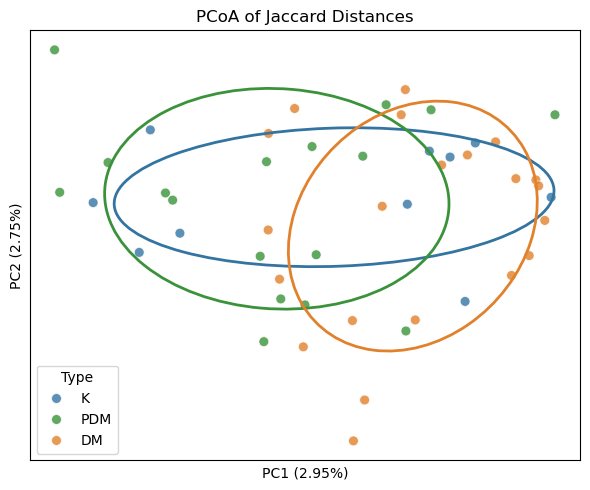

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Ellipse

custom_palette = {"K": "#3374A1", "DM": "#E1812C", "PDM": "#3A923A"}


def confidence_ellipse(x, y, ax, n_std=2.0, facecolor="none", **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # Eigenvalues and eigenvectors for ellipse orientation
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Ellipse angle and width/height
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse(
        (mean_x, mean_y), width, height, angle=theta, facecolor=facecolor, **kwargs
    )
    ax.add_patch(ellipse)


# Plot PCoA scatter plot
plt.figure(figsize=(6, 5))
ax = sns.scatterplot(
    data=pcoa_df, x="PC1", y="PC2", hue="Type", palette=custom_palette, s=50, alpha=0.8
)

# Add confidence ellipses for each group
for group in pcoa_df["Type"].unique():
    subset = pcoa_df[pcoa_df["Type"] == group]
    confidence_ellipse(
        subset["PC1"].values,
        subset["PC2"].values,
        ax,
        n_std=1.28,
        edgecolor=custom_palette[group],
        linewidth=2,
    )

plt.xticks([])
plt.yticks([])
# Add labels
ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}%)")
ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}%)")
ax.set_title("PCoA of Jaccard Distances")
#plt.savefig("./figures/v02/bray_curtis_pcoa.svg")

plt.tight_layout()
plt.show()

/tmp/ipykernel_784995/815600853.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}%)")
/tmp/ipykernel_784995/815600853.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}%)")
/tmp/ipykernel_784995/815600853.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_zlabel(f"PC3 ({pcoa_results.pr

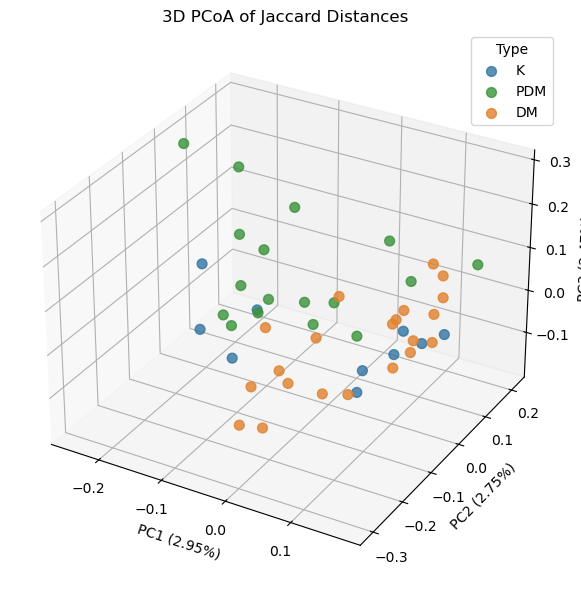

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Your custom color palette
custom_palette = {"K": "#3374A1", "DM": "#E1812C", "PDM": "#3A923A"}

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each group
for group in pcoa_df["Type"].unique():
    subset = pcoa_df[pcoa_df["Type"] == group]
    ax.scatter(
        subset["PC1"],
        subset["PC2"],
        subset["PC3"],
        label=group,
        color=custom_palette.get(group, "gray"),
        s=50,
        alpha=0.8
    )

# Axis labels with % variance explained
ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}%)")
ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}%)")
ax.set_zlabel(f"PC3 ({pcoa_results.proportion_explained[2]*100:.2f}%)")
ax.set_title("3D PCoA of Jaccard Distances")



plt.savefig("./figures/v02/jaccard_pcoa_3d.svg")

# Add legend and layout
ax.legend(title="Type")
plt.tight_layout()
plt.show()


## Heatmap

In [ ]:
# Unique to PDM
shared_PDM_DM_only = (taxa_PDM & taxa_DM) - taxa_K

# Unique to DM
unique_PDM = taxa_PDM - taxa_DM - taxa_K

# Unique to DM
unique_DM = taxa_DM - taxa_PDM - taxa_K

# Unique to DM
unique_K = taxa_K - taxa_DM - taxa_PDM

In [ ]:
shared_PDM_DM_only

In [ ]:
microbial_data_clinical = microbial_data_original.merge(
    metadata[["id", "Glukose1", "HbA1C (DCCT/NGSP)1"]], on="id", how="left"
)

In [ ]:
# Extract genus names from full taxonomy strings
bacteria_of_interest_short = [taxon.split(";")[-1] for taxon in shared_PDM_DM_only]
bacteria_of_interest_short = [b for b in bacteria_of_interest_short if b != ""]

In [ ]:
# Only keep the ones that actually match column names in df_plot
matched_bacteria = [
    b for b in bacteria_of_interest_short if b in microbial_data_clinical.columns
]

In [ ]:
matched_bacteria

In [ ]:
microbial_data_clinical = microbial_data_clinical.reset_index().rename(
    columns={"index": "Sample"}
)
df_long = microbial_data_clinical.melt(
    id_vars=["Sample", "Glukose1"], var_name="Bacteria", value_name="Abundance"
)

# Normalize abundance (optional for consistent dot sizes)
df_long["Abundance_norm"] = df_long["Abundance"] / df_long["Abundance"].max()

In [ ]:
### chao1 alpha

In [95]:
import pandas as pd
from skbio.diversity.alpha import chao1

In [227]:
otu_table = pd.read_csv("/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/dada2/ASV_table.tsv", sep = "\t")

In [228]:
otu_table.set_index("ASV_ID", inplace = True)

In [229]:
otu_table = otu_table.T

In [230]:
chao1_df = otu_table.apply(chao1, axis=1)

In [231]:
chao1_df = pd.DataFrame({
    "id": chao1_df.index,
    "chao1": chao1_df.values,
})

In [232]:
df_clean = chao1_df[
    pd.to_numeric(chao1_df["chao1"], errors="coerce").notnull()
].copy()

In [233]:
df_clean["chao1"] = df_clean["chao1"].astype(float)


In [234]:
order = ["K", "DM", "PDM"]
custom_palette = {
    "K": "#1f77b4",
    "DM": "#ff7f0e",
    "PDM": "#2ca02c",
}

In [235]:
df_clean = df_clean.merge(
    microbial_data[["id", "Type"]],
    on="id",
    how="left"
)


In [236]:
df_clean["Type"] = df_clean["Type"].replace(
    {"pankreopriver Diabetes": "PDM", "Diabetes mellitus Typ1": "DM", "Kontrolle": "K"}
)


0.7512945586546257
0.2380293908461294
0.11289279116504015


/tmp/ipykernel_784995/3190646866.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


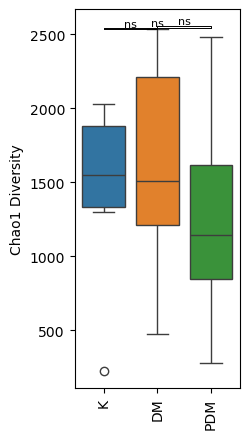

In [250]:
plt.figure(figsize=(2.6, 4.5))

ax = sns.boxplot(
    data=df_clean, x="Type", y="chao1", palette=custom_palette, order=order
)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Chao1 Diversity")

comparisons = [("K", "DM"), ("K", "PDM"), ("PDM", "DM")]
y_max = df_clean["chao1"].max()
h = 10  # vertical spacing between stars

for i, (group1, group2) in enumerate(comparisons):
    x1, x2 = order.index(group1), order.index(group2)
    y1 = df_clean[df_clean["Type"] == group1]["chao1"]
    y2 = df_clean[df_clean["Type"] == group2]["chao1"]


    stat, p = mannwhitneyu(y1, y2, alternative="two-sided")
    print(p)

    # Significance stars
    if p < 0.001:
        star = "***"
    elif p < 0.01:
        star = "**"
    elif p < 0.05:
        star = "*"
    else:
        star = "ns"

    # Draw lines and annotate
    y_line = y_max + h * i
    ax.plot([x1, x1, x2, x2], [y_line, y_line + 2, y_line + 2, y_line], lw=0.7, c="black")
    ax.text((x1 + x2) / 2, y_line + 2.5, star, ha="center", va="bottom", fontsize=8)

plt.tight_layout()

plt.savefig("./figures/v02/alpha_chao1.svg")
plt.show()

In [243]:
stat

124.0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import pandas as pd

# Example: assuming you already have a DataFrame called chao1_df
# with columns: ["SampleID", "Type", "chao1"]

# ---- Set up ---- #
order = ["K", "DM", "PDM"]
custom_palette = {
    "K": "#1f77b4",
    "DM": "#ff7f0e",
    "PDM": "#2ca02c",
}

# Clean data
df_clean = chao1_df[
    pd.to_numeric(chao1_df["chao1"], errors="coerce").notnull()
].copy()
df_clean["chao1"] = df_clean["chao1"].astype(float)

# ---- Plot ---- #
plt.figure(figsize=(2.6, 4.5))
ax = sns.boxplot(
    data=df_clean, x="Type", y="chao1", palette=custom_palette, order=order
)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Chao1 Diversity")

# ---- Add significance stars ---- #

